In [23]:
import json

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

annotations_dir_train = './annotations/person_keypoints_train2017.json'
images_dir_train = './train2017/'

annotations_dir_val = './annotations/person_keypoints_val2017.json'
images_dir_val = './val2017/'

# Read the json file and extract the annotations data for all images
def read_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

json_train_data = read_json(annotations_dir_train)
json_validation_data = read_json(annotations_dir_val)

    
image_keypoints = json_train_data['categories'][0]['keypoints']
images_list_train = json_train_data['images']
images_list_val = json_validation_data['images']

ids_list_train = []
ids_list_val = []
for each in zip(json_validation_data['annotations'], json_train_data['annotations']):
    ids_list_train.append(each[1]['image_id'])
    ids_list_val.append(each[0]['image_id'])

In [24]:
def pick_random_image(image_dir ,image_list, id_list, is_human=True):
    '''
    Pick a random image, choose if the image will have a human
    '''
    
    if is_human:
        human = False
        random_image_name = np.random.choice(image_list, 1)[0]['file_name']
        while not(human):
            if (int(random_image_name[:-4]) not in id_list):
                random_image_name = np.random.choice(image_list, 1)[0]['file_name']
            else:
                human = True
    else:
        random_image_name = np.random.choice(image_list, 1)[0]['file_name']
    
    img = plt.imread(image_dir + random_image_name)
    return img, random_image_name

In [51]:
img, name = pick_random_image(images_dir_val, images_list_val, ids_list_val, is_human=True)

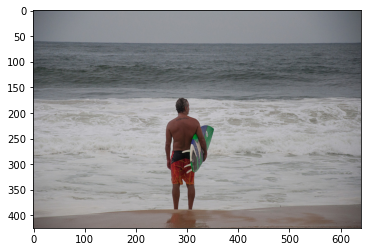

In [52]:
plt.imshow(img)

In [53]:
import torch
import torchvision.transforms as transforms

In [54]:
transform = transforms.Compose([transforms.Resize(256,192),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
def load_image(img):
    train_image = torch.from_numpy(img / 255.).permute(3, 2, 0, 1).float()
    train_box = 
    

In [ ]:
# Turn data into tensors
train_features_tensor = torch.from_numpy(train['X'] / 255.).permute(3, 2, 0, 1).float()
train_labels_tensor = torch.from_numpy(train['y']).squeeze().long()

test_features_tensor = torch.from_numpy(test['X'] / 255.).permute(3, 2, 0, 1).float()
test_labels_tensor = torch.from_numpy(test['y']).squeeze().long()